In [1]:
from langchain_community.vectorstores import Chroma
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import yaml
from yandex_chain import YandexEmbeddings

In [2]:
PATH = "../data_generations/data1"
CHROMA_PATH = os.path.join(PATH, "chromadir")
DISHES_PATH = os.path.join(PATH, "dishes")
SECRETS_YAML_PATH = "../ya_gpt_secrets.yaml"

In [3]:
from reading import read_dishes

N_CLUSTERS = 20
dishes, targets = read_dishes(DISHES_PATH, N_CLUSTERS)

N_dishes = len(dishes)

dish_to_num = {}
for i, name in enumerate(dishes):
    dish_to_num[name] = i

In [4]:
dish_to_num

{'уха судак': 0,
 'юшка судак': 6,
 'рыбный суп судак': 2,
 'судак бульон': 3,
 'ушной судак': 4,
 'юшка сiдмахи': 5,
 'рыбный юшец': 7,
 'булочка корица': 8,
 'сдобный булочка коричный посыпка': 9,
 'ароматный булочка пряность': 10,
 'коричный завиток': 11,
 'сладкий булочка  « секрет': 12,
 'корзинка коричный облако': 13,
 'булочка сдоба восточный вкус': 14,
 'пряный булочка': 15,
 'бефстроганов овощ': 16,
 'говядина строгановский овощной гарнир': 17,
 'говядина сметанный соус овощ': 18,
 'мясной рагу сливочный соус': 19,
 'бефстроганов классический рецепт тушеный овощ': 20,
 'русский кухня бефстроганов овощной гарнир': 21,
 'нежный говядина сочный овощ': 22,
 'изысканный мясной блюдо овощной дополнение': 23,
 'крем суп шампиньон': 24,
 'грибной крем суп': 25,
 'сливочный суп гриб': 26,
 'шампиньоновый крем пюре': 27,
 'грибной нежность': 28,
 'грибной блаженство': 29,
 'царский грибной суп': 30,
 'суп пюре шампиньон сливки': 31,
 'нежный сливочный грибной супчик': 32,
 'шашлык баран

In [5]:
with open(SECRETS_YAML_PATH) as f:
    secrets = yaml.load(f, Loader=yaml.FullLoader)
    FOLDER_ID = secrets['folder_id']
    API_KEY = secrets['api_key']

In [6]:
yandex_embs = YandexEmbeddings(folder_id=FOLDER_ID, api_key=API_KEY)
if not os.path.exists(CHROMA_PATH):
    docsearch = Chroma.from_texts(dishes, yandex_embs, persist_directory=CHROMA_PATH)
    docsearch.persist()
else:
    docsearch = Chroma(persist_directory=CHROMA_PATH, embedding_function=yandex_embs)

In [7]:
adjacency_matrix = np.zeros((N_dishes, N_dishes))
for i, (k, v) in enumerate(zip(dishes, targets)):
    for j, (k1, v1) in enumerate(zip(dishes, targets)):
        if v == v1:
            adjacency_matrix[i][j] = 1
adjacency_matrix

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [8]:
th = 0.2
pred_matrix_probs = np.zeros((N_dishes, N_dishes))
for i, (key, v) in enumerate(zip(dishes, targets)):
    docs = docsearch.similarity_search_with_relevance_scores(key, k=10)
    for doc in docs:
        if doc[1] > th:
            pred_matrix_probs[dish_to_num[key]][dish_to_num[doc[0].page_content]] = doc[1]
            pred_matrix_probs[dish_to_num[doc[0].page_content]][dish_to_num[key]] = doc[1]

pred_matrix_01 = np.sign(pred_matrix_probs)

/home/alex/.local/lib/python3.8/site-packages/langchain_core/vectorstores.py:311: UserWarning: Relevance scores must be between 0 and 1, got [(Document(page_content='уха судак'), 0.6352891584941343), (Document(page_content='ушной судак'), 0.5136324488548327), (Document(page_content='юшка судак'), 0.4255004383391575), (Document(page_content='юшка судак'), 0.4255004383391575), (Document(page_content='рыбный суп судак'), 0.3693299003358397), (Document(page_content='судак бульон'), 0.3340556855305261), (Document(page_content='рыбный юшец'), 0.166926656739124), (Document(page_content='юшка сiдмахи'), 0.021153604675585802), (Document(page_content='нежный шашлык ягненок'), -0.032738980459415146), (Document(page_content='сочный бараний шашлычок'), -0.03393949129239959)]
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/langchain_core/vectorstores.py:311: UserWarning: Relevance scores must be between 0 and 1, got [(Document(page_content='ушной судак'), 0.5956767685715945), (Documen

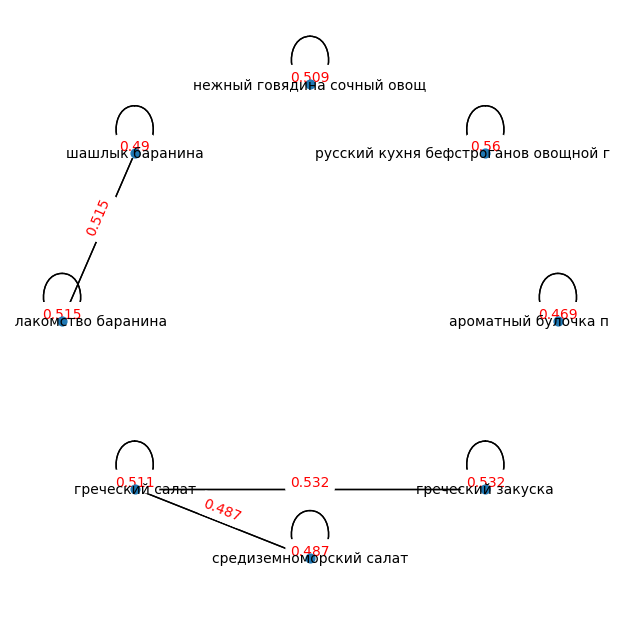

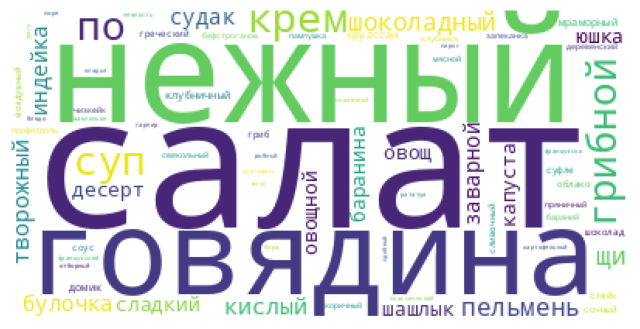

In [9]:
from painting import paint_part_of_graph, paint_world_cloud

paint_part_of_graph(dishes, pred_matrix_probs, ids = [10,21,22,33,34,35,66,67,68])

paint_world_cloud(dishes)

In [19]:
def print_metrics_mtx(y_true: np.matrix, y_pred: np.matrix, name = ""):
    y_true_arr = y_true.flatten()
    y_pred_arr = y_pred.flatten()

    if name:
        print(f"\n{name}\n")

    print("accuracy  ", accuracy_score(y_true_arr, y_pred_arr))
    print("precision ", precision_score(y_true_arr, y_pred_arr))
    print("recall    ", recall_score(y_true_arr, y_pred_arr))
    print("f1        ", f1_score(y_true_arr, y_pred_arr))

In [11]:
from closure import one_step_closure

pred_matrix_01_cl = one_step_closure(pred_matrix_01)

pred_matrix_01_cl_cl = one_step_closure(pred_matrix_01_cl)

In [20]:
print_metrics_mtx(adjacency_matrix, pred_matrix_01, "Simple chroma metrics:")

print_metrics_mtx(adjacency_matrix, pred_matrix_01_cl, "Chroma + one step closure metrics:")

print_metrics_mtx(adjacency_matrix, pred_matrix_01_cl_cl, "Chroma + two steps closure metrics:")


Simple chroma metrics:

accuracy   0.9724694434555595
precision  0.7957099080694586
recall     0.6109803921568627
f1         0.6912156166814553

Chroma + one step closure metrics:

accuracy   0.9618685969700566
precision  0.5866295264623955
recall     0.8258823529411765
f1         0.6859934853420195

Chroma + two steps closure metrics:

accuracy   0.8935959811716309
precision  0.3077967943493616
recall     0.8886274509803922
f1         0.4572235673930589


In [13]:
from estimation_m import estimate_m

m_est = estimate_m(pred_matrix_01)

In [14]:
from matchlift import match_lift

pred_matrix_cvxpy = match_lift(pred_matrix_probs, N_CLUSTERS, 0.5)

In [15]:
from rounding import rounding_matrix

pred_matrix_cvxpy_01 = np.sign(np.around(pred_matrix_cvxpy))

pred_matrix_cvxpy_rounding_01 = rounding_matrix(pred_matrix_cvxpy_01, N_CLUSTERS)

In [21]:
print_metrics_mtx(adjacency_matrix, pred_matrix_cvxpy_01, "MatchLift with oracle m")

print_metrics_mtx(adjacency_matrix, pred_matrix_cvxpy_rounding_01, "Rounded MatchLift with oracle m")


MatchLift with oracle m

accuracy   0.9805387445116887
precision  0.8377911993097498
recall     0.7615686274509804
f1         0.7978635990139687

Rounded MatchLift with oracle m

accuracy   0.9790356394129979
precision  0.8186484174508126
recall     0.7505882352941177
f1         0.7831423895253683
